In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import font_manager as fm
import re  # <--- IMPORT THIS for the formatting
from sklearn.svm import SVC
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec

In [24]:
df_oxides = pd.read_csv('../data/Final_data/results_oxide_all.csv')
df_sulfides = pd.read_csv('../data/Final_data/results_sulfide_all.csv')
df_selenides = pd.read_csv('../data/Final_data/results_selenide_all.csv')
df_tellurides = pd.read_csv('../data/Final_data/results_telluride_all.csv')

df_orbital_radii = pd.read_csv('../data/Orbital_radii/orbital_radii.csv')
df_orbital_radii.rename(columns={'Atom':'Element'}, inplace=True)

In [25]:
columns_to_keep = ['Formula','A','B','X','Ehull_min','Ehull_min_type','SuperScore','inversion_parameter','SMACT_low','SMACT_medium','SMACT_high']
df_oxides = df_oxides[columns_to_keep]
df_sulfides = df_sulfides[columns_to_keep]
df_selenides = df_selenides[columns_to_keep]
df_tellurides = df_tellurides[columns_to_keep]

In [26]:
df_oxides

,Formula,A,B,X,Ehull_min,Ehull_min_type,SuperScore,inversion_parameter,SMACT_low,SMACT_medium,SMACT_high
0,AgAg2O4,Ag,Ag,O,0.203885,equal,0.450,NaN,True,False,False
1,AgAl2O4,Ag,Al,O,0.104262,normal,0.480,0.00,True,False,False
2,AgAs2O4,Ag,As,O,0.106265,inverse,0.455,1.00,True,False,False
3,AgAu2O4,Ag,Au,O,0.161421,inverse,0.190,0.99,True,False,False
4,AgB2O4,Ag,B,O,0.142806,inverse,0.600,1.00,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
5052,ZrW2O4,Zr,W,O,1.516774,normal,NaN,NaN,True,False,False
5053,ZrY2O4,Zr,Y,O,0.186146,inverse,NaN,NaN,True,False,False
5054,ZrYb2O4,Zr,Yb,O,NaN,NaN,NaN,NaN,True,True,False
5055,ZrZn2O4,Zr,Zn,O,0.121095,inverse,NaN,NaN,True,True,True


In [27]:
df_orbital_radii

,Element,rs,rp,rd
0,Li,0.985,0.625,NaN
1,Be,0.640,0.440,NaN
2,B,0.480,0.315,NaN
3,C,0.390,0.250,NaN
4,N,0.330,0.210,NaN
...,...,...,...,...
65,Pb,0.960,1.130,0.450
66,Bi,0.920,1.077,0.438
67,Po,0.880,1.020,0.425
68,At,0.850,0.980,0.475


In [28]:
##Map orbital radii (rs, rp, rd) to df_oxides, df_sulfides, df_selenides, df_tellurides
def map_orbital_radii(df, df_orbital_radii, element_col_A, element_col_B):
    df = df.copy()
    df[f'Rs_{element_col_A}'] = df[element_col_A].map(df_orbital_radii.set_index('Element')['rs'])
    df[f'Rp_{element_col_A}'] = df[element_col_A].map(df_orbital_radii.set_index('Element')['rp'])
    df[f'Rd_{element_col_A}'] = df[element_col_A].map(df_orbital_radii.set_index('Element')['rd'])

    df[f'Rs_{element_col_B}'] = df[element_col_B].map(df_orbital_radii.set_index('Element')['rs'])
    df[f'Rp_{element_col_B}'] = df[element_col_B].map(df_orbital_radii.set_index('Element')['rp'])
    df[f'Rd_{element_col_B}'] = df[element_col_B].map(df_orbital_radii.set_index('Element')['rd'])

    # return df[(df['SMACT_medium']==True) & (df['SuperScore'].notna())][['Formula','A','B','X','energy_normal','energy_inverse','Ehull_min','Ehull_min_type','inversion_parameter','SuperScore', f'Rs_{element_col_A}', f'Rp_{element_col_A}', f'Rd_{element_col_A}', f'Rs_{element_col_B}', f'Rp_{element_col_B}', f'Rd_{element_col_B}']]
    return df[(df['SMACT_medium']==True) & (df['SuperScore'].notna())]

df_oxides_orb_mapped = map_orbital_radii(df_oxides, df_orbital_radii, 'A', 'B')
df_sulfides_orb_mapped = map_orbital_radii(df_sulfides, df_orbital_radii, 'A', 'B')
df_selenides_orb_mapped = map_orbital_radii(df_selenides, df_orbital_radii, 'A', 'B')
df_tellurides_orb_mapped = map_orbital_radii(df_tellurides, df_orbital_radii, 'A', 'B')

In [29]:
df_oxides_orb_mapped

,Formula,A,B,X,Ehull_min,Ehull_min_type,SuperScore,inversion_parameter,SMACT_low,SMACT_medium,SMACT_high,Rs_A,Rp_A,Rd_A,Rs_B,Rp_B,Rd_B
27,AgMn2O4,Ag,Mn,O,0.057182,normal,0.490,0.0,True,True,False,1.045,1.330,0.385,0.99,1.23,0.230
40,AgRh2O4,Ag,Rh,O,0.090016,normal,0.465,0.0,True,True,False,1.045,1.330,0.385,1.11,1.41,0.420
57,AgV2O4,Ag,V,O,0.126423,normal,0.275,0.0,True,True,False,1.045,1.330,0.385,1.09,1.34,0.260
71,AlCo2O4,Al,Co,O,0.081603,inverse,0.350,1.0,True,True,False,0.770,0.905,NaN,0.92,1.10,0.210
76,AlEu2O4,Al,Eu,O,0.161987,inverse,0.360,1.0,True,True,False,0.770,0.905,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,ZrCa2O4,Zr,Ca,O,0.057245,normal,0.590,0.0,True,True,True,1.265,1.560,0.540,1.32,1.68,0.340
5004,ZrCu2O4,Zr,Cu,O,0.189030,inverse,0.095,1.0,True,True,True,1.265,1.560,0.540,0.88,1.16,0.185
5021,ZrMn2O4,Zr,Mn,O,0.062705,inverse,0.600,1.0,True,True,True,1.265,1.560,0.540,0.99,1.23,0.230
5029,ZrPb2O4,Zr,Pb,O,0.110499,inverse,0.305,1.0,True,True,True,1.265,1.560,0.540,0.96,1.13,0.450


In [30]:
##Calculate R_A and R_B
def calculate_R_A_R_B(df):
    df = df.copy()
    df = df[(df['Rs_A'].notna()) & (df['Rp_A'].notna()) & (df['Rs_B'].notna()) & (df['Rp_B'].notna())].copy()
    df['R_A'] = df['Rs_A'] + df['Rp_A']
    df['R_B'] = df['Rs_B'] + df['Rp_B']
    return df

df_oxides_orb_calc = calculate_R_A_R_B(df_oxides_orb_mapped)
df_sulfides_orb_calc = calculate_R_A_R_B(df_sulfides_orb_mapped)
df_selenides_orb_calc = calculate_R_A_R_B(df_selenides_orb_mapped)
df_tellurides_orb_calc = calculate_R_A_R_B(df_tellurides_orb_mapped)

In [31]:
df_oxides_orb_calc

,Formula,A,B,X,Ehull_min,Ehull_min_type,SuperScore,inversion_parameter,SMACT_low,SMACT_medium,SMACT_high,Rs_A,Rp_A,Rd_A,Rs_B,Rp_B,Rd_B,R_A,R_B
27,AgMn2O4,Ag,Mn,O,0.057182,normal,0.490,0.0,True,True,False,1.045,1.330,0.385,0.99,1.23,0.230,2.375,2.22
40,AgRh2O4,Ag,Rh,O,0.090016,normal,0.465,0.0,True,True,False,1.045,1.330,0.385,1.11,1.41,0.420,2.375,2.52
57,AgV2O4,Ag,V,O,0.126423,normal,0.275,0.0,True,True,False,1.045,1.330,0.385,1.09,1.34,0.260,2.375,2.43
71,AlCo2O4,Al,Co,O,0.081603,inverse,0.350,1.0,True,True,False,0.770,0.905,NaN,0.92,1.10,0.210,1.675,2.02
77,AlFe2O4,Al,Fe,O,0.119641,inverse,0.410,1.0,True,True,False,0.770,0.905,NaN,0.95,1.16,0.220,1.675,2.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,ZrCa2O4,Zr,Ca,O,0.057245,normal,0.590,0.0,True,True,True,1.265,1.560,0.540,1.32,1.68,0.340,2.825,3.00
5004,ZrCu2O4,Zr,Cu,O,0.189030,inverse,0.095,1.0,True,True,True,1.265,1.560,0.540,0.88,1.16,0.185,2.825,2.04
5021,ZrMn2O4,Zr,Mn,O,0.062705,inverse,0.600,1.0,True,True,True,1.265,1.560,0.540,0.99,1.23,0.230,2.825,2.22
5029,ZrPb2O4,Zr,Pb,O,0.110499,inverse,0.305,1.0,True,True,True,1.265,1.560,0.540,0.96,1.13,0.450,2.825,2.09


In [32]:
def orbital_radii_plot(df_normal_spinels, df_inverse_spinels, title_suffix):
    plt.rcParams['figure.dpi'] = 150
    plt.rcParams['savefig.dpi'] = 150

    # Use ARIAL font format
    fm.fontManager.addfont('../font/ARIAL.TTF')
    plt.rcParams['font.family'] = 'Arial'

    # Data preparation
    normal_spinels = df_normal_spinels.copy()
    inverse_spinels = df_inverse_spinels.copy()

    # Set colors
    normal_color = '#ed1f24'
    inverse_color = '#3953a4'

    # Prepare normal and inverse data for SVM
    X_normal = normal_spinels[['R_A', 'R_B']].dropna()
    X_inverse = inverse_spinels[['R_A', 'R_B']].dropna()

    # Labels: 0 for Normal, 1 for Inverse
    y_normal = np.zeros(len(X_normal))
    y_inverse = np.ones(len(X_inverse))

    X = np.vstack((X_normal, X_inverse))
    y = np.hstack((y_normal, y_inverse))

    # Fit SVC Model
    clf = SVC(kernel='linear', C=100)
    clf.fit(X, y)

    # Plotting Setup
    # Use GridSpec to handle the marginal plots
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

    # Define Axes
    ax_main = fig.add_subplot(gs[1:4, 0:3])
    ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
    ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

    # Hide ticks for marginals where they touch the main plot
    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)
    ax_top.set_yticks([])   # Hide Y-ticks for top density
    ax_right.set_xticks([]) # Hide X-ticks for right density

    # Main Scatter Plot
    ax_main.scatter(normal_spinels['R_A'], normal_spinels['R_B'], 
                    color=normal_color, label=f'Normal {len(normal_spinels)}', s=50, edgecolors='white', linewidths=0.8)
    ax_main.scatter(inverse_spinels['R_A'], inverse_spinels['R_B'], 
                    color=inverse_color, label=f'Inverse {len(inverse_spinels)}', s=50, edgecolors='white', linewidths=0.8)

    # Add Density Plots (KDE)
    def plot_kde(ax, data, color, vertical=False):
        # Calculate Kernel Density Estimate
        kde = gaussian_kde(data)
        
        if not vertical:
            x_grid = np.linspace(data.min()-0.5, data.max()+0.5, 200)
            ax.plot(x_grid, kde(x_grid), color=color, lw=1.5)
            ax.fill_between(x_grid, kde(x_grid), color=color, alpha=0.3)
        else:
            y_grid = np.linspace(data.min()-0.5, data.max()+0.5, 200)
            ax.plot(kde(y_grid), y_grid, color=color, lw=1.5)
            ax.fill_betweenx(y_grid, 0, kde(y_grid), color=color, alpha=0.3)
        
        # Remove borders for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False) if not vertical else None
        ax.spines['bottom'].set_visible(False) if vertical else None

    # Plot X-axis distribution)
    plot_kde(ax_top, normal_spinels['R_A'].dropna(), normal_color, vertical=False)
    plot_kde(ax_top, inverse_spinels['R_A'].dropna(), inverse_color, vertical=False)

    # Plot Y-axis distribution)
    plot_kde(ax_right, normal_spinels['R_B'].dropna(), normal_color, vertical=True)
    plot_kde(ax_right, inverse_spinels['R_B'].dropna(), inverse_color, vertical=True)
    ax_main.set_xlabel('$R_s(A) + R_p(A)$ / (Å)', fontsize=12)
    ax_main.set_ylabel('$R_s(B) + R_p(B)$ / (Å)', fontsize=12)
    ax_main.legend(loc='upper right', frameon=True, fontsize=10)
    ax_main.grid(True, linestyle=':', alpha=0.6)

    # fig.suptitle('Orbital radii separation maps for all spinels', y=0.92, fontsize=14)
    plt.tight_layout()
    plt.savefig(f'Orbital_radii_separation_map_{title_suffix}.pdf')
    return plt.show()

In [33]:
df_normal_spinels_ehull = pd.concat([
    df_oxides_orb_calc[(df_oxides_orb_calc['Ehull_min_type']=='normal')],
    df_sulfides_orb_calc[(df_sulfides_orb_calc['Ehull_min_type']=='normal')],
    df_selenides_orb_calc[(df_selenides_orb_calc['Ehull_min_type']=='normal')],
    df_tellurides_orb_calc[(df_tellurides_orb_calc['Ehull_min_type']=='normal')]
    ])
df_inverse_spinels_ehull = pd.concat([
    df_oxides_orb_calc[(df_oxides_orb_calc['Ehull_min_type']=='inverse')],
    df_sulfides_orb_calc[(df_sulfides_orb_calc['Ehull_min_type']=='inverse')],
    df_selenides_orb_calc[(df_selenides_orb_calc['Ehull_min_type']=='inverse')],
    df_tellurides_orb_calc[(df_tellurides_orb_calc['Ehull_min_type']=='inverse')]
    ])

df_normal_spinels_inv_param = pd.concat([
    df_oxides_orb_calc[(round(df_oxides_orb_calc['inversion_parameter'])==0)],
    df_sulfides_orb_calc[(round(df_sulfides_orb_calc['inversion_parameter'])==0)],
    df_selenides_orb_calc[(round(df_selenides_orb_calc['inversion_parameter'])==0)],
    df_tellurides_orb_calc[(round(df_tellurides_orb_calc['inversion_parameter'])==0)]
    ])
df_inverse_spinels_inv_param = pd.concat([
    df_oxides_orb_calc[(round(df_oxides_orb_calc['inversion_parameter'])==1)],
    df_sulfides_orb_calc[(round(df_sulfides_orb_calc['inversion_parameter'])==1)],
    df_selenides_orb_calc[(round(df_selenides_orb_calc['inversion_parameter'])==1)],
    df_tellurides_orb_calc[(round(df_tellurides_orb_calc['inversion_parameter'])==1)]
    ])

/var/folders/kk/nqtw878x2378f1fj2vbr6sv80000gp/T/ipykernel_31818/3458233702.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


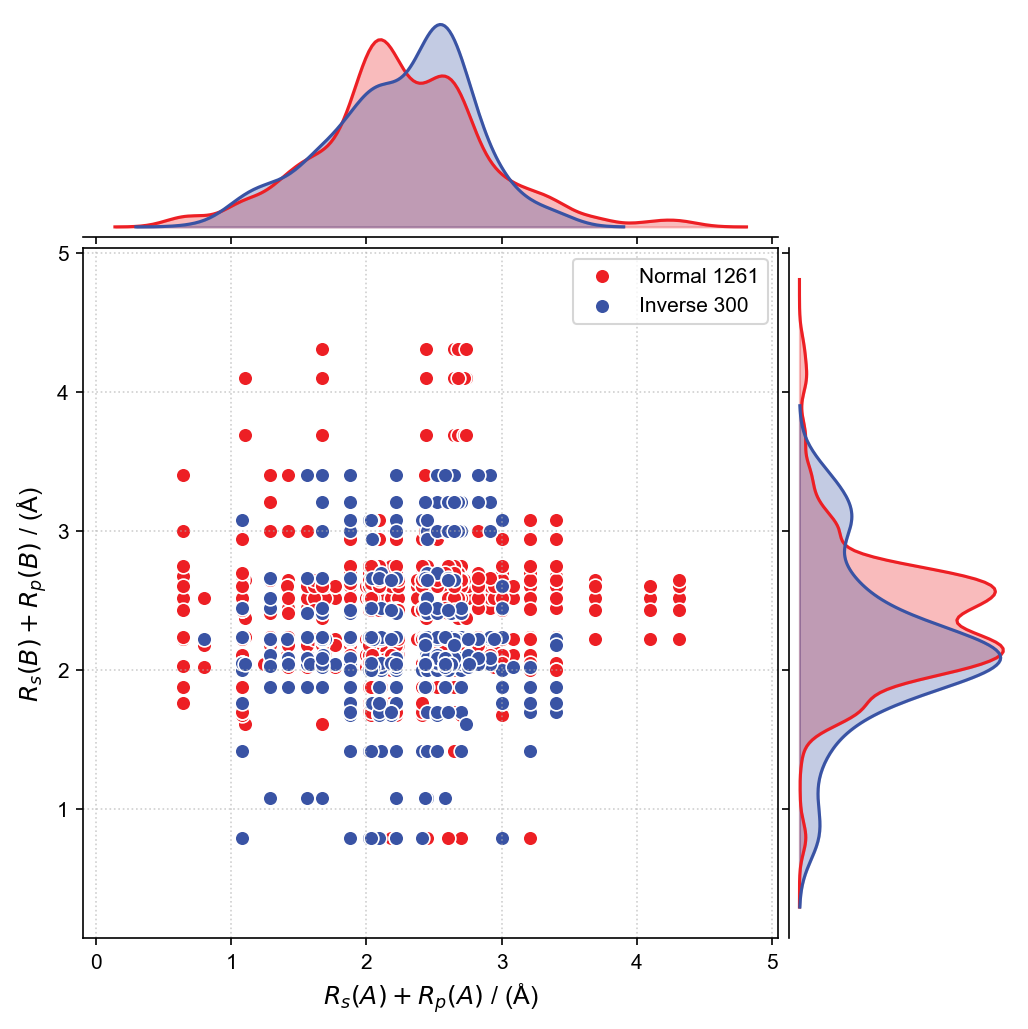

In [34]:
orbital_radii_plot(df_normal_spinels_ehull, df_inverse_spinels_ehull, 'ehull')

/var/folders/kk/nqtw878x2378f1fj2vbr6sv80000gp/T/ipykernel_31818/3458233702.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


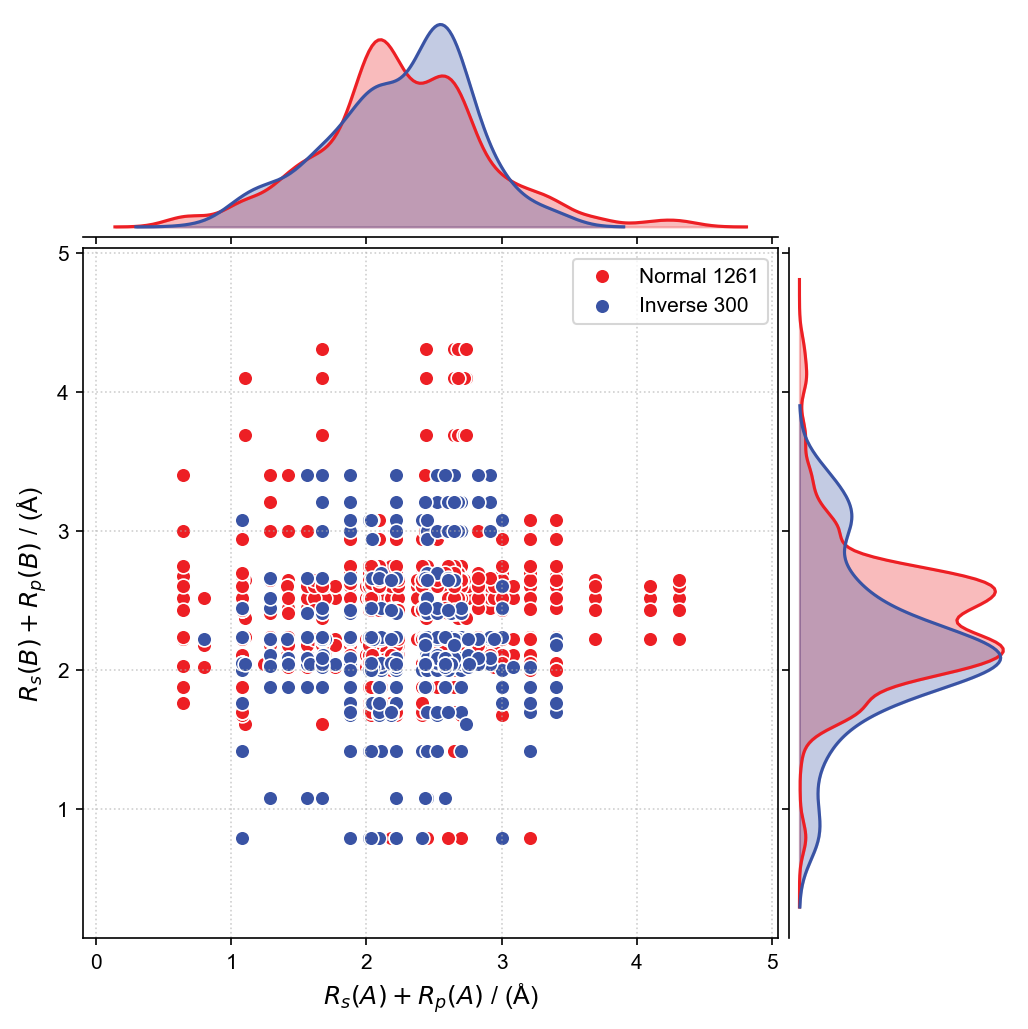

In [35]:
orbital_radii_plot(df_normal_spinels_inv_param, df_inverse_spinels_inv_param, 'inv_param')